In [1]:
import ast
import glob
import warnings
from collections import defaultdict
from datetime import date

import numpy as np
import pandas as pd
import wandb

today = date.today()
api = wandb.Api()

# # Find all csv files in the current directory
csv_files = glob.glob("csv/*.csv")
# # Collect all the names of the csv files without the extension
csv_names = [csv_file[:-4] for csv_file in csv_files]
project_name = "6g_12th_July"  
user = "telyatnikov_sap"

if project_name not in csv_names:
    runs = api.runs(f"{user}/{project_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list}
    )

    runs_df.to_csv(f"csv/{user}_{project_name}.csv")
else:
    runs_df = pd.read_csv(f"csv/{user}_{project_name}.csv", index_col=0)

    for row in runs_df.iloc:
        row["summary"] = ast.literal_eval(row["summary"])
        row["config"] = ast.literal_eval(row["config"])


for row in runs_df.iloc:
    row["summary"].update(row["config"])

lst = [i["summary"] for i in runs_df.iloc]
df = pd.DataFrame.from_dict(lst)

df_init = df.copy()


In [2]:
def normalize_column(df, column_to_normalize):
    # Use json_normalize to flatten the nested dictionaries into separate columns
    flattened_df = pd.json_normalize(df[column_to_normalize])
    # Rename columns to include 'nested_column' prefix
    flattened_df.columns = [
        f"{column_to_normalize}.{col}" for col in flattened_df.columns
    ]
    # Concatenate the flattened DataFrame with the original DataFrame
    result_df = pd.concat([df, flattened_df], axis=1)
    # Get new columns names
    new_columns = flattened_df.columns
    # Drop the original nested column if needed
    result_df.drop(column_to_normalize, axis=1, inplace=True)
    return result_df, new_columns


# Config columns to normalize
columns_to_normalize = ["decoder"]

# Keep track of config columns added
config_columns = []
for column in columns_to_normalize:
    df, columns = normalize_column(df, column)
    config_columns.extend(columns)

In [7]:
from collections import defaultdict

results = defaultdict(dict)
df['model_type'].dropna(inplace=True)
#df[['model_type',  'decoder.use_trace_loss', 'Token compression', 'val/best_accuracy', 'validate_snr_db']]
df['model_type'] = df['model_type'].apply(lambda x: ' '.join(x.split('_')[-2:]))

In [8]:
df = df.loc[df['reconstruct_images'] == True]

In [9]:


# df.experiments_dir df.experiment_name
# Go over the rows and create path
new_col = []
for i, row in df.iterrows():
    new_col.append(f"{row['experiments_dir']}{row['experiment_name']}/images")

df['path'] = new_col

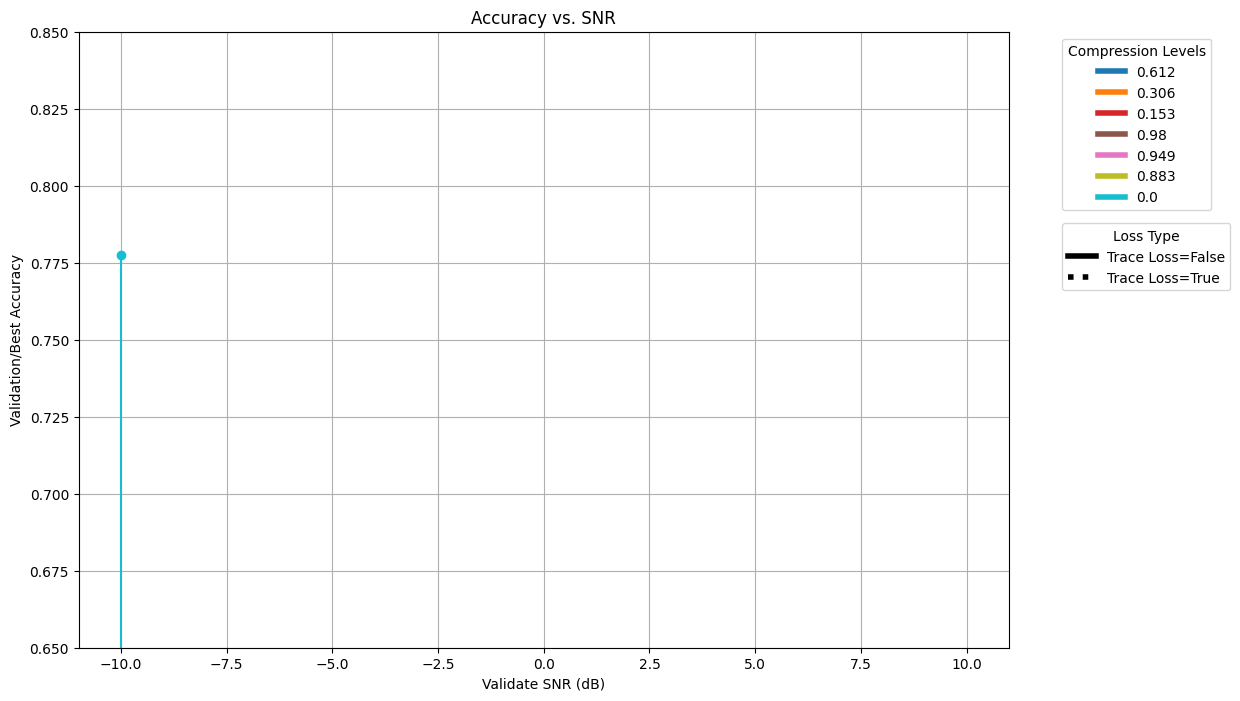

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Drop rows where 'val/best_accuracy' is None
df = df.dropna(subset=['val/best_accuracy'])

# Define unique combinations of 'model_type', 'Token compression', and 'decoder.use_trace_loss'
combine_columns = ['model_type', 'Token compression', 'decoder.use_trace_loss']
unique_combinations = df[combine_columns].drop_duplicates()

# Assign a unique color for every Token compression level
unique_token_compression = unique_combinations['Token compression'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_token_compression)))

# Create a dictionary to map Token compression levels to colors
color_dict = {unique_token_compression[i]: colors[i] for i in range(len(unique_token_compression))}

# Create the plot
plt.figure(figsize=(12, 8))

# Iterate over each unique combination of parameters
for _, combination in unique_combinations.iterrows():
    model_type = combination['model_type']
    
    # Filter for 'models sequential' model type
    if model_type == 'models sequential':
        # Create the mask for filtering the dataframe
        selected_idx = [df[key] == val for key, val in combination.items()]
        mask = np.logical_and.reduce(selected_idx)
        subset = df[mask]
        
        # Plot the data
        plt.plot(
            subset['validate_snr_db'],
            subset['val/best_accuracy'], 
            marker='o',
            color=color_dict[combination['Token compression']],
            linestyle='dotted' if combination['decoder.use_trace_loss'] else 'solid'
        )

# Create custom legend elements for line styles
line_styles = {"Trace Loss=False": 'solid', "Trace Loss=True": 'dotted'}
legend_elements2 = [Line2D([0], [0], color='black', lw=4, linestyle=val, label=key) for key, val in line_styles.items()]

# Create custom legend elements for compression levels
legend_elements1 = [Line2D([0], [0], color=color, lw=4, label=f"{np.round(1 - compression_level, 4)}") for compression_level, color in color_dict.items()]

# Add legends to the plot
plt.gca().add_artist(plt.legend(handles=legend_elements1, title="Compression Levels", bbox_to_anchor=(1.05, 1), loc='upper left'))
plt.legend(handles=legend_elements2, title="Loss Type", bbox_to_anchor=(1.05, 0.7), loc='upper left')

# Add plot titles and labels
plt.title('Accuracy vs. SNR')
plt.xlabel('Validate SNR (dB)')
plt.ylabel('Validation/Best Accuracy')
plt.ylim(0.65, 0.85)
# Add grid
plt.grid(True)
output_pdf_path = f"images/performance_plot_{today}.pdf"
plt.savefig(output_pdf_path, bbox_inches='tight')
# Show plot
plt.show()


In [27]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Define unique combinations of 'model_type' and 'Token compression'
combine_columns = ['model_type', 'Token compression', 'decoder.use_trace_loss', 'classfy_images']
unique_combinations = df[combine_columns].drop_duplicates()

ids = [0, 392, 784, 1176, 1568, 1960, 2352, 2744, 3136, 3528, 3920]
decoder_use_trace_loss = False
classfy_images = False
for id_img_to_show in ids:

    for _, combination in unique_combinations.iterrows():
        model_type = combination['model_type']
        if (model_type == 'models sequential') and (combination['decoder.use_trace_loss'] == decoder_use_trace_loss) and (combination['classfy_images'] == classfy_images):
        
            token_compression = np.round(1 - np.round(combination['Token compression'], 4), 4)
            
            label = ''
            selected_idx = []
            for key,val in combination.items():
                selected_idx.append(df[key] == val)

                label += f'{key}={val}, '
            
            mask = np.logical_and.reduce(selected_idx)

            subset = df[mask]
            # Create dict snr to img_path
            d = {}
            for i, row in subset.iterrows():
                validate_snr_db = row.validate_snr_db
                img_path = glob.glob(row.path+f'/epoch_100/*/*{id_img_to_show}.png')[0]

                d[validate_snr_db] = {'img_path': img_path}
            
            # Get keys from smallest to largest
            keys = sorted(d.keys()) 

            # List of your images (replace with your actual image data)
            image_paths = [(d[key]['img_path'], key) for key in keys]


            # Create a new figure
            fig = plt.figure(figsize=(10, 8))

            # Iterate through images
            for i, val in enumerate(image_paths):
                img_path, key = val
                image = Image.open(img_path)
                # Add subplot for each image
                ax = fig.add_subplot(1, len(image_paths), i + 1)
                
                # Display the image
                ax.imshow(image)
                
                # Annotate with number above each image
                ax.annotate(str(key), xy=(0.5, 1.05), xycoords='axes fraction',
                            ha='center', va='bottom', fontsize=12)
                
                # Hide axes
                ax.axis('off')

            # Add a title 
            #plt.suptitle(f"Compression level {combination['Token compression']}", fontsize=10, )
            # make a suptitle but with smaller gap from titile to image
            plt.suptitle(f"Compression level {token_compression} (1 - num_transmitted_tokens % num_init_tokens)", fontsize=10, y=0.9)
            # Add y axis label

            # Adjust layout
            plt.tight_layout()
            # Save or display the figure
            #plt.savefig(f"images/image_idx={id_img_to_show}_compression_{token_compression}.png", dpi=300)  # Save the figure
            plt.savefig(f"images/image_idx={id_img_to_show}_compression_{token_compression}_{label}.png", dpi=300)  # Save the figure
            plt.close(fig)
    
    # Create one pdf
    import os 
    image_paths = sorted(glob.glob(f'images/image_idx={id_img_to_show}*.png'))[::-1]
    # Load and stuck toghether into one pdf
    from PIL import Image

    def load_images(image_paths):
        """Load images from given paths and convert to RGB."""
        images = []
        for path in image_paths:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            images.append(img)
        return images

    image_paths = [img_path for img_path in image_paths]


    #a = [(path, float(".".join(path.split('_')[-1].split('.')[:-1]))) for path in image_paths]
    a = [(path, float(path.split('_')[3])) for path in image_paths]
    # Sort by  second arg of tuple
    a = sorted(a, key=lambda x: x[1])

    image_paths = [x[0] for x in a]

    images = load_images(image_paths)



    output_pdf_path = f"images/image_idx={id_img_to_show}|use_trace_loss={decoder_use_trace_loss}|classfy_images={classfy_images}.pdf"
    if images:
        images[0].save(output_pdf_path, save_all=True, append_images=images[1:], quality=95)

    print(f'Images have been saved to {output_pdf_path}')

    # Delete image_paths
    for img_path in image_paths:
        os.remove(img_path)
        print(f'{img_path} has been removed')

            

Images have been saved to images/image_idx=0|use_trace_loss=False|classfy_images=False.pdf
images/image_idx=0_compression_0.0_model_type=models sequential, Token compression=1.0, decoder.use_trace_loss=False, classfy_images=True, .png has been removed
images/image_idx=0_compression_0.0_model_type=models sequential, Token compression=1.0, decoder.use_trace_loss=False, classfy_images=False, .png has been removed
images/image_idx=0_compression_0.153_model_type=models sequential, Token compression=0.847, decoder.use_trace_loss=False, classfy_images=False, .png has been removed
images/image_idx=0_compression_0.306_model_type=models sequential, Token compression=0.694, decoder.use_trace_loss=False, classfy_images=False, .png has been removed
images/image_idx=0_compression_0.612_model_type=models sequential, Token compression=0.388, decoder.use_trace_loss=False, classfy_images=False, .png has been removed
images/image_idx=0_compression_0.883_model_type=models sequential, Token compression=0.1

'images/image_idx=0_compression_0.98_model_type=models sequential, Token compression=0.02, decoder.use_trace_loss=False, classfy_images=False, .png'

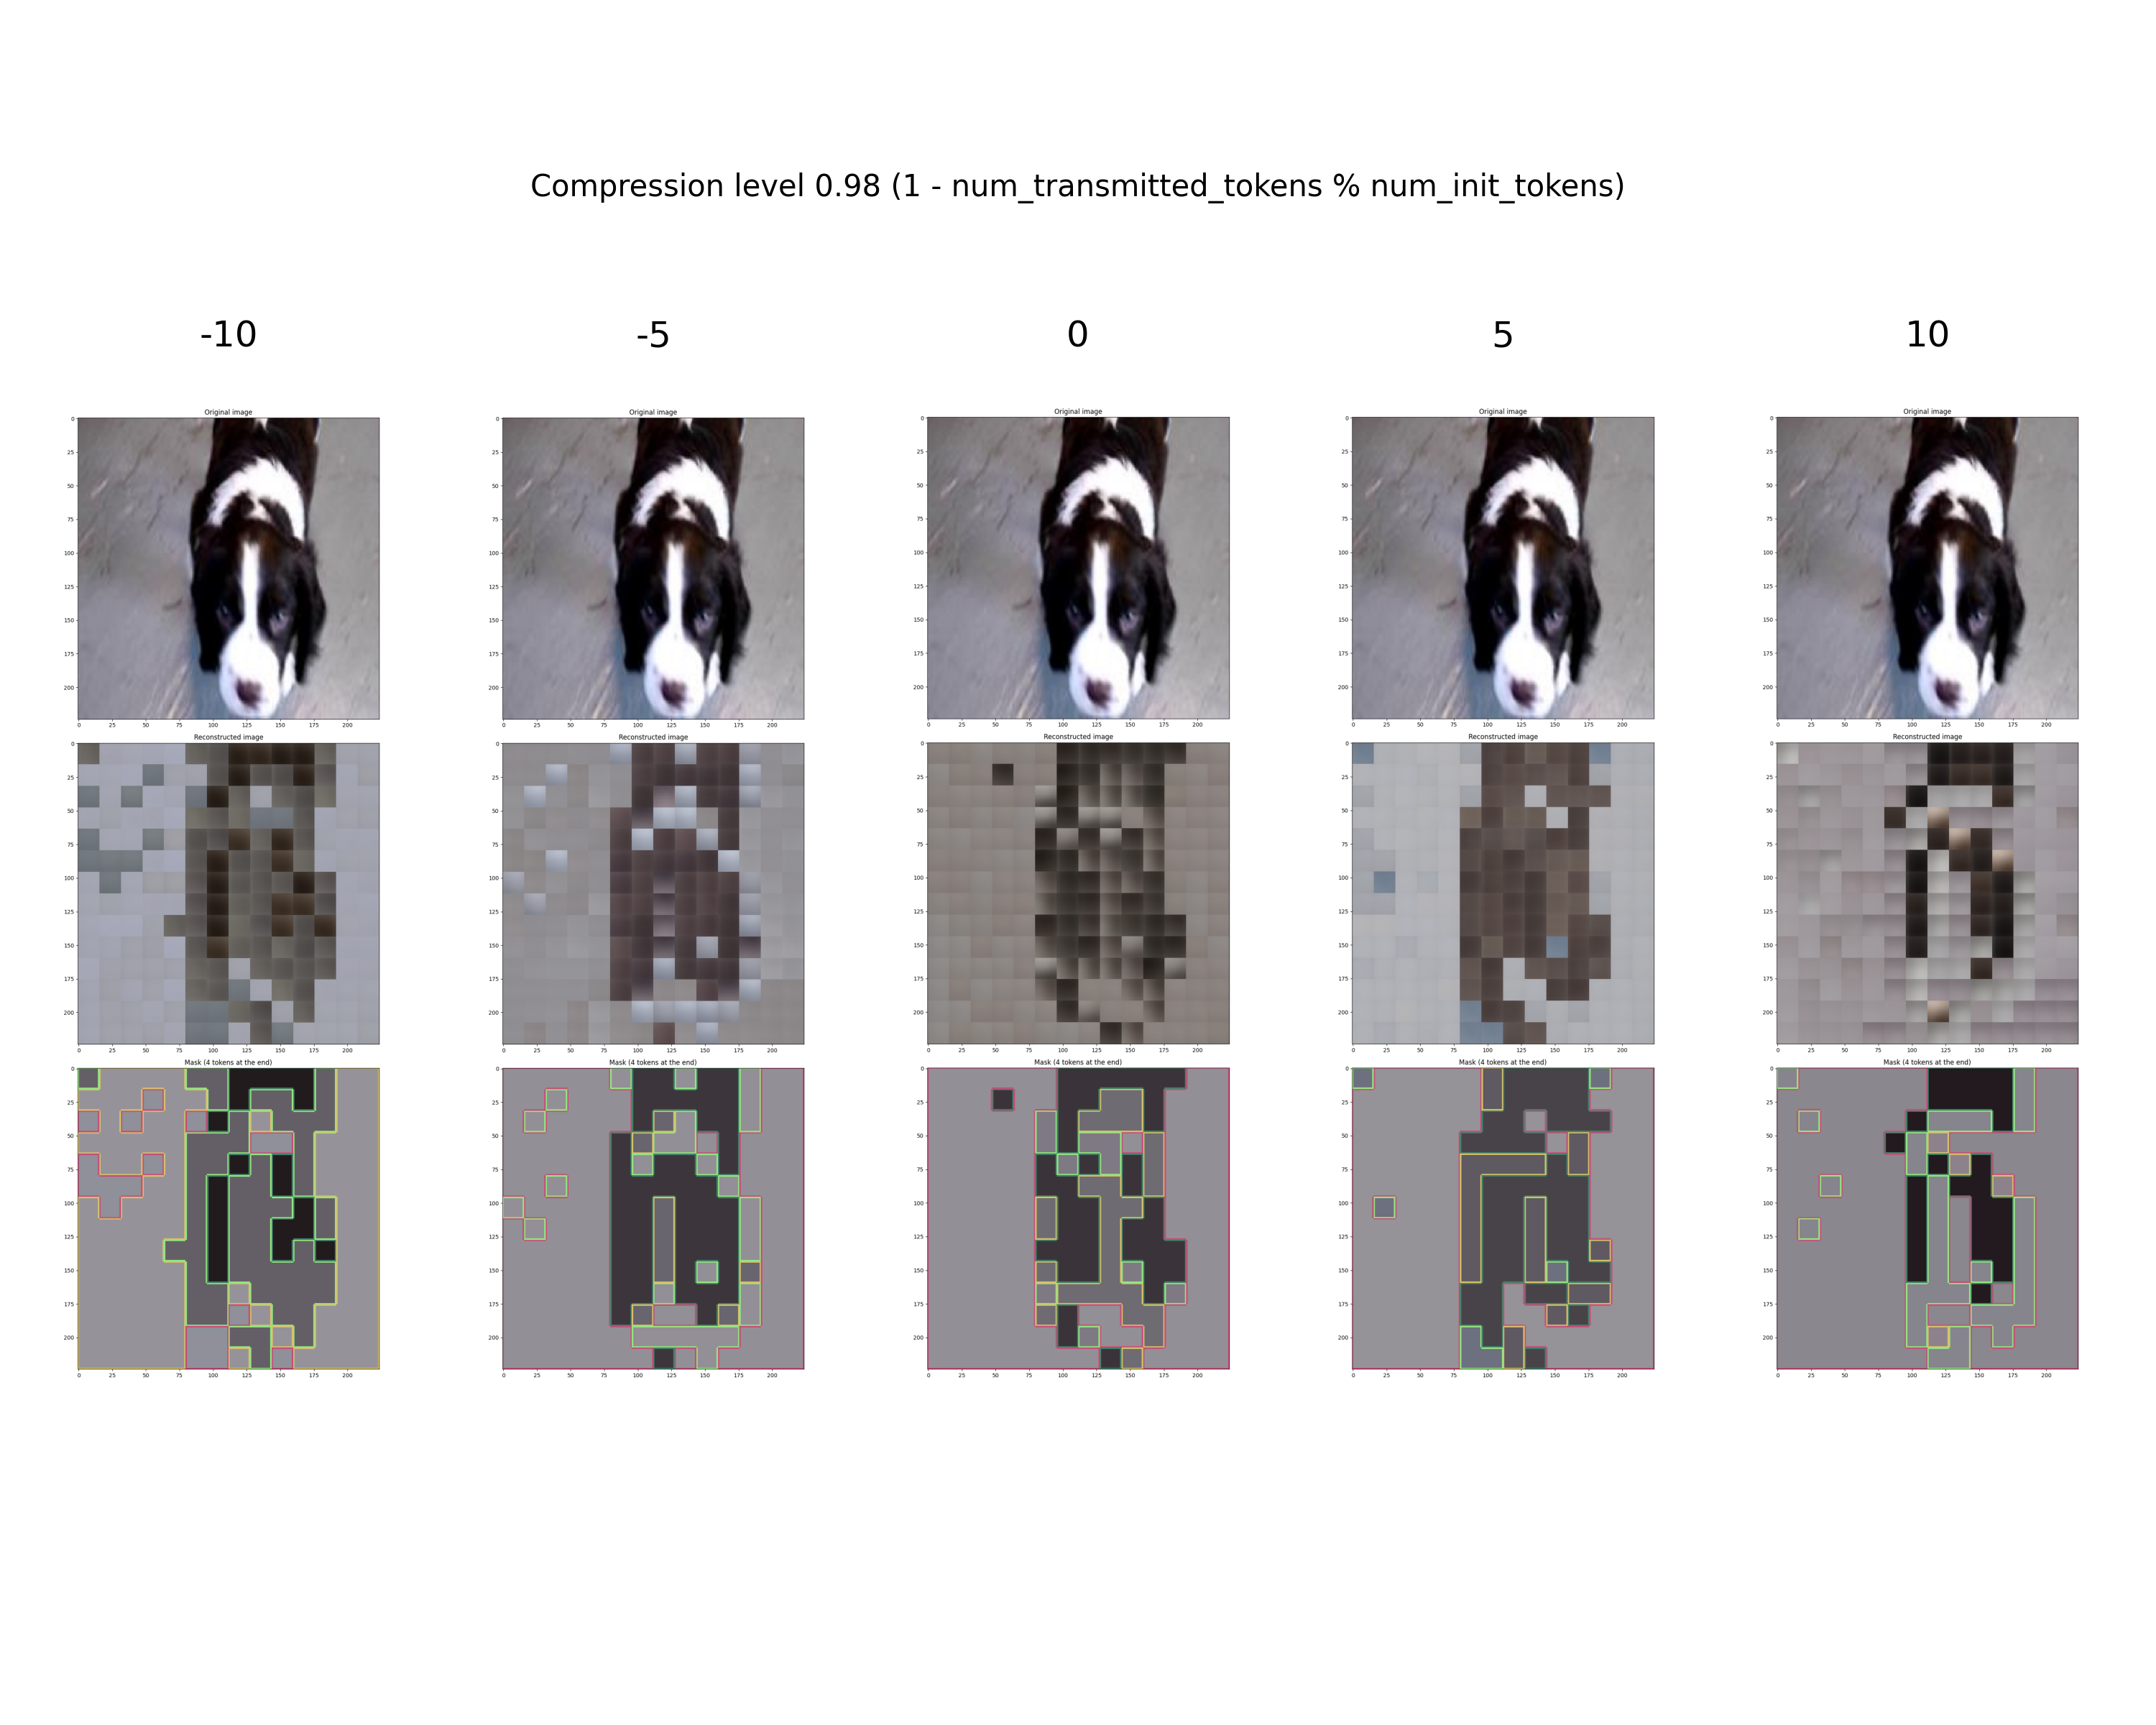

In [85]:
# sort by Token compression
unique_combinations = unique_combinations.sort_values(by=['Token compression'])

In [86]:
unique_combinations

,model_type,Token compression,decoder.use_trace_loss
10,models sequential,0.020,False
15,models sequential,0.051,False
20,models sequential,0.117,False
25,models sequential,0.388,False
30,models sequential,0.694,False
1,models sequential,0.847,True
35,models sequential,0.847,False
40,models sequential,1.000,False


In [87]:
df[(df['model_type'] == model_type) & (df['Token compression'] == token_compression)]

,_step,val/mse,val/accuracy,train/total_loss,val/classification_loss,train/classification_loss,_runtime,val/loss,_timestamp,train/mse_loss,...,decoder._target_,decoder.num_heads,decoder.hidden_dim,decoder.image_size,decoder.num_layers,decoder.patch_size,decoder.num_classes,decoder.use_trace_loss,decoder.timm_pretrained_weights,path
40,15421.0,0.090887,0.886879,0.185275,0.463094,0.06302,2033.754298,0.553982,1.719360e+09,0.122255,...,peekvit.models.vit_lev.VisionTransformerDecoder,3,192,224,12,16,10,False,"[facebookresearch/deit:main, deit_tiny_patch16...",log/runs/2024-06-26-01-28-03/images
41,15421.0,0.097897,0.886369,0.185275,0.462493,0.06302,2019.462847,0.560390,1.719358e+09,0.122255,...,peekvit.models.vit_lev.VisionTransformerDecoder,3,192,224,12,16,10,False,"[facebookresearch/deit:main, deit_tiny_patch16...",log/runs/2024-06-26-00-53-53/images
42,15421.0,0.118430,0.884841,0.185275,0.461609,0.06302,2018.649272,0.580039,1.719356e+09,0.122255,...,peekvit.models.vit_lev.VisionTransformerDecoder,3,192,224,12,16,10,False,"[facebookresearch/deit:main, deit_tiny_patch16...",log/runs/2024-06-26-00-19-44/images
43,15421.0,0.171625,0.881783,0.185275,0.464354,0.06302,2020.048423,0.635979,1.719354e+09,0.122255,...,peekvit.models.vit_lev.VisionTransformerDecoder,3,192,224,12,16,10,False,"[facebookresearch/deit:main, deit_tiny_patch16...",log/runs/2024-06-25-23-45-34/images
44,15421.0,0.308467,0.864204,0.185275,0.483776,0.06302,2035.450054,0.792243,1.719352e+09,0.122255,...,peekvit.models.vit_lev.VisionTransformerDecoder,3,192,224,12,16,10,False,"[facebookresearch/deit:main, deit_tiny_patch16...",log/runs/2024-06-25-23-11-06/images


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Dropping rows where val/best_accuracy is None
df = df.dropna(subset=['val/best_accuracy'])


# Define unique combinations of 'model_type' and 'Token compression'
combine_columns = ['model_type', 'Token compression','decoder.use_trace_loss']
unique_combinations = df[combine_columns].drop_duplicates()


# assign a unique color for every Token compression level
unique_token_compression = unique_combinations['Token compression'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_token_compression)))

color_dict = {unique_token_compression[i]: colors[i] for i in range(len(unique_token_compression))}

# Plotting
plt.figure(figsize=(12, 8))

for _, combination in unique_combinations.iterrows():
    model_type = combination['model_type']
    if (model_type == 'models sequential'): # and (combination['decoder.use_trace_loss'] == False)
    
        token_compression = 1 - np.round(combination['Token compression'], 4)
        
        label = ''
        selected_idx = []
        for key,val in combination.items():
            selected_idx.append(df[key] == val)
            
            if 'Token compression' == key:
                val = np.round(1 - np.round(val, 4),4)
            
                label += f'{key}={val}, '
        
        mask = np.logical_and.reduce(selected_idx)

        subset = df[mask]
        
        plt.plot(subset['validate_snr_db'],
            subset['val/best_accuracy'], 
            marker='o',
            #label=label,
            color=color_dict[combination['Token compression']],
            linestyle='dotted' if combination['decoder.use_trace_loss'] else 'solid'
        )

line_styles = {"Trace Loss=False":'solid', "Trace Loss=True":'dotted'}  # Solid and dotted lines
legend_elements2 = [Line2D([0], [0], color='black', lw=4, linestyle=val, label=key) for key, val in line_styles.items()]
plt.legend(handles=legend_elements2, title="Line Types", bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Create custom legend
legend_elements1 = [Line2D([0], [0], color=color, lw=4, label=f"{np.round(1-compression_level,4)}") for compression_level, color in color_dict.items()]
plt.legend(handles=legend_elements1, title="Compression Levels", bbox_to_anchor=(1.05, 1), loc='upper left')

# Create custom legend elements for the second legend box with line styles

# Show all legends
plt.gca().add_artist(plt.legend(handles=legend_elements1,bbox_to_anchor=(1.05, 1),title="Compression levels" ))
plt.legend(handles=legend_elements2, title="Loss type", bbox_to_anchor=(1.05, 0.7), loc='upper left')


plt.title('Accuracy vs. SNR')
plt.xlabel('Validate SNR (dB)')
plt.ylabel('Validation/Best Accuracy')
#plt.legend(title='Model Type and Token Compression', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
